<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/PPG_CNN%2BGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# 0. 라이브러리 & 시드
# =========================
import h5py
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [13]:
# 1. p096530.mat 로드
# =========================
mat_path = "/content/drive/MyDrive/Colab Notebooks/p096530.mat"

f = h5py.File(mat_path, "r")
subj = f["Subj_Wins"]
refs = f["#refs#"]

def read_cell(obj, idx):
    """MATLAB cell(1xN) -> numpy array"""
    ref = obj[0, idx]
    return np.array(refs[ref])

print("Subj_Wins keys:", list(subj.keys()))

Subj_Wins keys: ['ABP_F', 'ABP_Lag', 'ABP_Raw', 'ABP_SPeaks', 'ABP_Turns', 'Age', 'CaseID', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'ECG_Record', 'ECG_Record_F', 'Gender', 'IncludeFlag', 'PPG_ABP_Corr', 'PPG_F', 'PPG_Raw', 'PPG_Record', 'PPG_Record_F', 'PPG_SPeaks', 'PPG_Turns', 'SegDBP', 'SegSBP', 'SegmentID', 'SubjectID', 'T', 'WinID', 'WinSeqID']


In [14]:
# 2. PPG, SBP, DBP, 시간 추출
# =========================
N_total = subj["PPG_F"].shape[1]  # ex) 2200 세그먼트
print("총 세그먼트 수 (원본):", N_total)

ppg_list = []
sbp_list = []
dbp_list = []
t_list   = []

for i in range(N_total):
    # PPG 세그먼트: (1, 1250) -> (1250,)
    ppg = read_cell(subj["PPG_F"], i).astype(np.float32).reshape(-1)
    ppg_list.append(ppg)

    # SBP / DBP: (1,1) -> scalar
    sbp = read_cell(subj["SegSBP"], i).astype(np.float32)[0, 0]
    dbp = read_cell(subj["SegDBP"], i).astype(np.float32)[0, 0]
    sbp_list.append(sbp)
    dbp_list.append(dbp)

    # 시간 T: (1,1250) 중 첫 샘플만 사용해서 정렬
    T  = read_cell(subj["T"], i).astype(np.float64)
    t_list.append(float(T[0, 0]))

ppg_arr = np.stack(ppg_list, axis=0)   # (N_total, 1250)
sbp_arr = np.array(sbp_list)           # (N_total,)
dbp_arr = np.array(dbp_list)
t_arr   = np.array(t_list)

print("PPG shape:", ppg_arr.shape)
print("SBP/DBP shape:", sbp_arr.shape, dbp_arr.shape)

총 세그먼트 수 (원본): 2200
PPG shape: (2200, 1250)
SBP/DBP shape: (2200,) (2200,)


In [15]:
# 3. 환자 번호(SubjectID) 출력
# =========================
subj_id_arr = read_cell(subj["SubjectID"], 0)  # ASCII 코드
patient_id = "".join(chr(int(c)) for c in subj_id_arr.reshape(-1))
print("환자 번호(SubjectID):", patient_id)

환자 번호(SubjectID): p096530


In [16]:
# 4. 시간순 정렬 후 앞 2000 세그먼트만 사용
# =========================
order = np.argsort(t_arr)  # 시간 기준 오름차순 인덱스
ppg_sorted = ppg_arr[order]
sbp_sorted = sbp_arr[order]
dbp_sorted = dbp_arr[order]

max_segments = 2000
if ppg_sorted.shape[0] < max_segments:
    raise ValueError(f"2000 세그먼트 필요, 현재 {ppg_sorted.shape[0]}개입니다.")

ppg_sorted = ppg_sorted[:max_segments]
sbp_sorted = sbp_sorted[:max_segments]
dbp_sorted = dbp_sorted[:max_segments]

N = max_segments
L = ppg_sorted.shape[1]
print("최종 사용 세그먼트 수:", N)
print("세그먼트 길이:", L)

최종 사용 세그먼트 수: 2000
세그먼트 길이: 1250


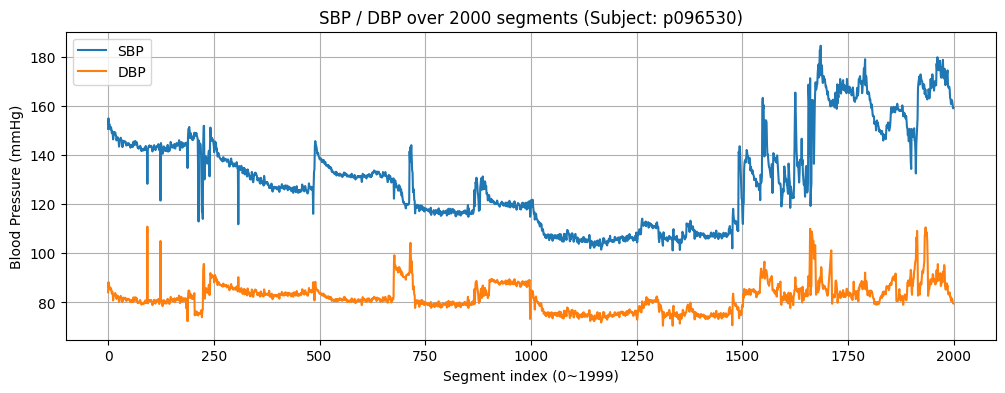

In [17]:
# 5. SBP/DBP 전체 구간 그래프
# =========================
plt.figure(figsize=(12, 4))
plt.plot(sbp_sorted, label="SBP")
plt.plot(dbp_sorted, label="DBP")
plt.title(f"SBP / DBP over 2000 segments (Subject: {patient_id})")
plt.xlabel("Segment index (0~1999)")
plt.ylabel("Blood Pressure (mmHg)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# 6. 입력/타깃 텐서 (PPG only)
#    X: (N, L, 1)
#    y: (N, 2)  [SBP, DBP]
# =========================
X_all = ppg_sorted[..., np.newaxis]               # (2000, 1250, 1)
y_all = np.stack([sbp_sorted, dbp_sorted], axis=1)  # (2000, 2)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

X_all shape: (2000, 1250, 1)
y_all shape: (2000, 2)


In [19]:
# 7. PPG only CNN+GRU 모델 정의
# =========================
def build_ppg_cnn_gru(input_shape):
    """
    PPG only -> [SBP, DBP] 회귀
    CNN + GRU 모델
    input_shape: (L, 1)
    """
    inp = layers.Input(shape=input_shape)

    # --- CNN feature extractor ---
    x = layers.Conv1D(32, kernel_size=7, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(x)

    # --- GRU ---
    x = layers.GRU(64, return_sequences=False)(x)

    # --- Dense ---
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(2, activation="linear")(x)   # [SBP, DBP]

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse"   # 회귀, SBP/DBP 동시에
    )
    return model

In [20]:
# 8. 5-fold 시간 연속 교차검증 설정
# =========================
fold_size = 320 + 40 + 40  # 400
num_folds = 5

if N < fold_size * num_folds:
    raise ValueError(f"세그먼트 수 부족: 필요 {fold_size * num_folds}, 현재 {N}")

print("총 세그먼트:", N)
print("fold_size:", fold_size, "num_folds:", num_folds)

총 세그먼트: 2000
fold_size: 400 num_folds: 5


In [21]:
# 9. 5-fold CV 함수
# =========================
def run_time_series_cv_ppg_cnn_gru(X_all, y_all):
    mae_sbp_list = []
    mae_dbp_list = []
    rmse_sbp_list = []
    rmse_dbp_list = []

    for fold in range(num_folds):
        start = fold * fold_size
        end   = start + fold_size
        fold_idx = np.arange(start, end)

        # 시간 순서 유지: 앞 320 train, 다음 40 val, 마지막 40 test
        train_idx = fold_idx[:320]
        val_idx   = fold_idx[320:360]
        test_idx  = fold_idx[360:400]

        X_train = X_all[train_idx]
        y_train = y_all[train_idx]
        X_val   = X_all[val_idx]
        y_val   = y_all[val_idx]
        X_test  = X_all[test_idx]
        y_test  = y_all[test_idx]

        # ------- 입력 PPG 스케일링 -------
        N_tr, L_, C_ = X_train.shape
        scaler = StandardScaler()

        X_train_flat = X_train.reshape(N_tr, -1)
        X_train_scaled = scaler.fit_transform(X_train_flat).reshape(N_tr, L_, C_)

        N_val = X_val.shape[0]
        X_val_scaled = scaler.transform(X_val.reshape(N_val, -1)).reshape(N_val, L_, C_)

        N_te = X_test.shape[0]
        X_test_scaled = scaler.transform(X_test.reshape(N_te, -1)).reshape(N_te, L_, C_)

        # ------- 모델 생성 & 학습 -------
        model = build_ppg_cnn_gru((L_, C_))

        es = callbacks.EarlyStopping(
            monitor="val_loss",
            patience=20,
            restore_best_weights=True
        )

        print(f"\n[PPG only CNN+GRU] Fold {fold+1}/{num_folds} 학습 시작")
        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=200,
            batch_size=16,
            verbose=1,
            callbacks=[es]
        )

        # ------- 테스트 평가 -------
        y_pred = model.predict(X_test_scaled)

        mae_sbp = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
        mae_dbp = mean_absolute_error(y_test[:, 1], y_pred[:, 1])

        rmse_sbp = np.sqrt(mean_squared_error(y_test[:, 0], y_pred[:, 0]))
        rmse_dbp = np.sqrt(mean_squared_error(y_test[:, 1], y_pred[:, 1]))

        mae_sbp_list.append(mae_sbp)
        mae_dbp_list.append(mae_dbp)
        rmse_sbp_list.append(rmse_sbp)
        rmse_dbp_list.append(rmse_dbp)

        print(f"[PPG only CNN+GRU] Fold {fold+1} 결과:")
        print(f"  MAE  SBP: {mae_sbp:.3f}, DBP: {mae_dbp:.3f}")
        print(f"  RMSE SBP: {rmse_sbp:.3f}, DBP: {rmse_dbp:.3f}")

    # ------- 5-fold 평균 & 표준편차 -------
    mae_sbp_mean = np.mean(mae_sbp_list)
    mae_sbp_std  = np.std(mae_sbp_list)
    mae_dbp_mean = np.mean(mae_dbp_list)
    mae_dbp_std  = np.std(mae_dbp_list)

    rmse_sbp_mean = np.mean(rmse_sbp_list)
    rmse_sbp_std  = np.std(rmse_sbp_list)
    rmse_dbp_mean = np.mean(rmse_dbp_list)
    rmse_dbp_std  = np.std(rmse_dbp_list)

    print("\n====================================")
    print("PPG only CNN+GRU 5-fold 최종 요약")
    print("----- MAE -----")
    print(f" SBP: 평균 {mae_sbp_mean:.3f}, 표준편차 {mae_sbp_std:.3f}")
    print(f" DBP: 평균 {mae_dbp_mean:.3f}, 표준편차 {mae_dbp_std:.3f}")
    print("----- RMSE -----")
    print(f" SBP: 평균 {rmse_sbp_mean:.3f}, 표준편차 {rmse_sbp_std:.3f}")
    print(f" DBP: 평균 {rmse_dbp_mean:.3f}, 표준편차 {rmse_dbp_std:.3f}")
    print("====================================")

    return {
        "mae_sbp_list": mae_sbp_list,
        "mae_dbp_list": mae_dbp_list,
        "rmse_sbp_list": rmse_sbp_list,
        "rmse_dbp_list": rmse_dbp_list,
        "mae_sbp_mean": mae_sbp_mean,
        "mae_sbp_std": mae_sbp_std,
        "mae_dbp_mean": mae_dbp_mean,
        "mae_dbp_std": mae_dbp_std,
        "rmse_sbp_mean": rmse_sbp_mean,
        "rmse_sbp_std": rmse_sbp_std,
        "rmse_dbp_mean": rmse_dbp_mean,
        "rmse_dbp_std": rmse_dbp_std,
    }

In [22]:
# 10. 5-fold 실행
# =========================
results_ppg_cnn_gru = run_time_series_cv_ppg_cnn_gru(X_all, y_all)


[PPG only CNN+GRU] Fold 1/5 학습 시작
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 13436.1553 - val_loss: 11386.5488
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12304.8457 - val_loss: 10070.3145
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10905.9727 - val_loss: 8555.6484
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9241.1523 - val_loss: 6844.8320
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7349.4038 - val_loss: 5081.4580
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5637.6919 - val_loss: 3449.4517
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3885.9763 - val_loss: 2105.9214
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2478.2693 - val_loss: 1140.5006
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1612.4381 - val_loss: 539.6305
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1094.6760 - val_loss: 216.3727
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1